In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from ForecastSimulator2 import Forecastsimulator, forecast_split
from statsmodels.tsa.seasonal import seasonal_decompose
from datetime import date
from dateutil.relativedelta import relativedelta
from sklearn.ensemble import BaggingRegressor

from tensorflow.keras.layers import Conv1D, LSTM, Dense, Dropout, Bidirectional, TimeDistributed, GRU
from tensorflow.keras.layers import MaxPooling1D, Flatten
from tensorflow.keras.regularizers import L1, L2
from sklearn.preprocessing import StandardScaler
from pandas_datareader import data as web

plt.rcParams['figure.figsize'] = (18, 10)
plt.rcParams['axes.labelsize'] = 15
plt.rcParams['axes.grid'] = True

In [2]:
today = date.today()
start_date = today - relativedelta(years=7)

print(start_date)
data = pd.DataFrame(web.DataReader('MERC', 'stooq', start_date))
data.info()

2016-03-19
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1761 entries, 2023-03-17 to 2016-03-21
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    1761 non-null   float64
 1   High    1761 non-null   float64
 2   Low     1761 non-null   float64
 3   Close   1761 non-null   float64
 4   Volume  1761 non-null   float64
dtypes: float64(5)
memory usage: 82.5 KB


In [3]:
close = data[['Close']]
close = close.sort_index(ascending = True)
close

,Close
Date,
2016-03-21,6.94516
2016-03-22,6.75805
2016-03-23,6.52559
2016-03-24,6.78591
2016-03-28,6.87255
...,...
2023-03-13,10.13000
2023-03-14,10.15000
2023-03-15,9.84000


In [4]:
def lstm(ws=30, dtp=1, multi=2):
    
    model = tf.keras.Sequential()

    # LSTM layers
    model.add(LSTM(multi*ws, return_sequences=True))
    model.add(Dense(5, kernel_regularizer=L2(0.2)))
    model.add(LSTM(multi*ws, return_sequences=True))
    model.add(Dense(5, kernel_regularizer=L2(0.2)))
    model.add(LSTM(multi*ws, return_sequences=True))
    model.add(Dense(5, kernel_regularizer=L2(0.2)))
    model.add(LSTM(multi*ws, return_sequences=False))
    model.add(Dense(5, kernel_regularizer=L2(0.2)))

    #Final layers
    model.add(Dense(dtp, activation='linear'))
    model.compile(optimizer='Adamax', loss='mse', metrics=['mse', 'mae', 'mape'])

    return model

Epoch 1/50
75/75 - 7s - loss: 6.1694 - mse: 0.6249 - mae: 0.6128 - mape: 98.5500 - 7s/epoch - 91ms/step
Epoch 2/50
75/75 - 1s - loss: 3.5764 - mse: 0.1153 - mae: 0.2712 - mape: 110.5229 - 719ms/epoch - 10ms/step
Epoch 3/50
75/75 - 1s - loss: 2.2625 - mse: 0.1065 - mae: 0.2594 - mape: 103.9452 - 743ms/epoch - 10ms/step
Epoch 4/50
75/75 - 1s - loss: 1.4375 - mse: 0.1061 - mae: 0.2577 - mape: 103.6706 - 747ms/epoch - 10ms/step
Epoch 5/50
75/75 - 1s - loss: 0.9320 - mse: 0.1065 - mae: 0.2569 - mape: 118.5476 - 731ms/epoch - 10ms/step
Epoch 6/50
75/75 - 1s - loss: 0.6276 - mse: 0.1047 - mae: 0.2548 - mape: 111.1252 - 756ms/epoch - 10ms/step
Epoch 7/50
75/75 - 1s - loss: 0.4419 - mse: 0.1042 - mae: 0.2526 - mape: 110.3712 - 711ms/epoch - 9ms/step
Epoch 8/50
75/75 - 1s - loss: 0.3295 - mse: 0.1027 - mae: 0.2510 - mape: 109.0899 - 719ms/epoch - 10ms/step
Epoch 9/50
75/75 - 1s - loss: 0.2664 - mse: 0.1053 - mae: 0.2526 - mape: 102.4365 - 762ms/epoch - 10ms/step
Epoch 10/50
75/75 - 1s - loss: 0.

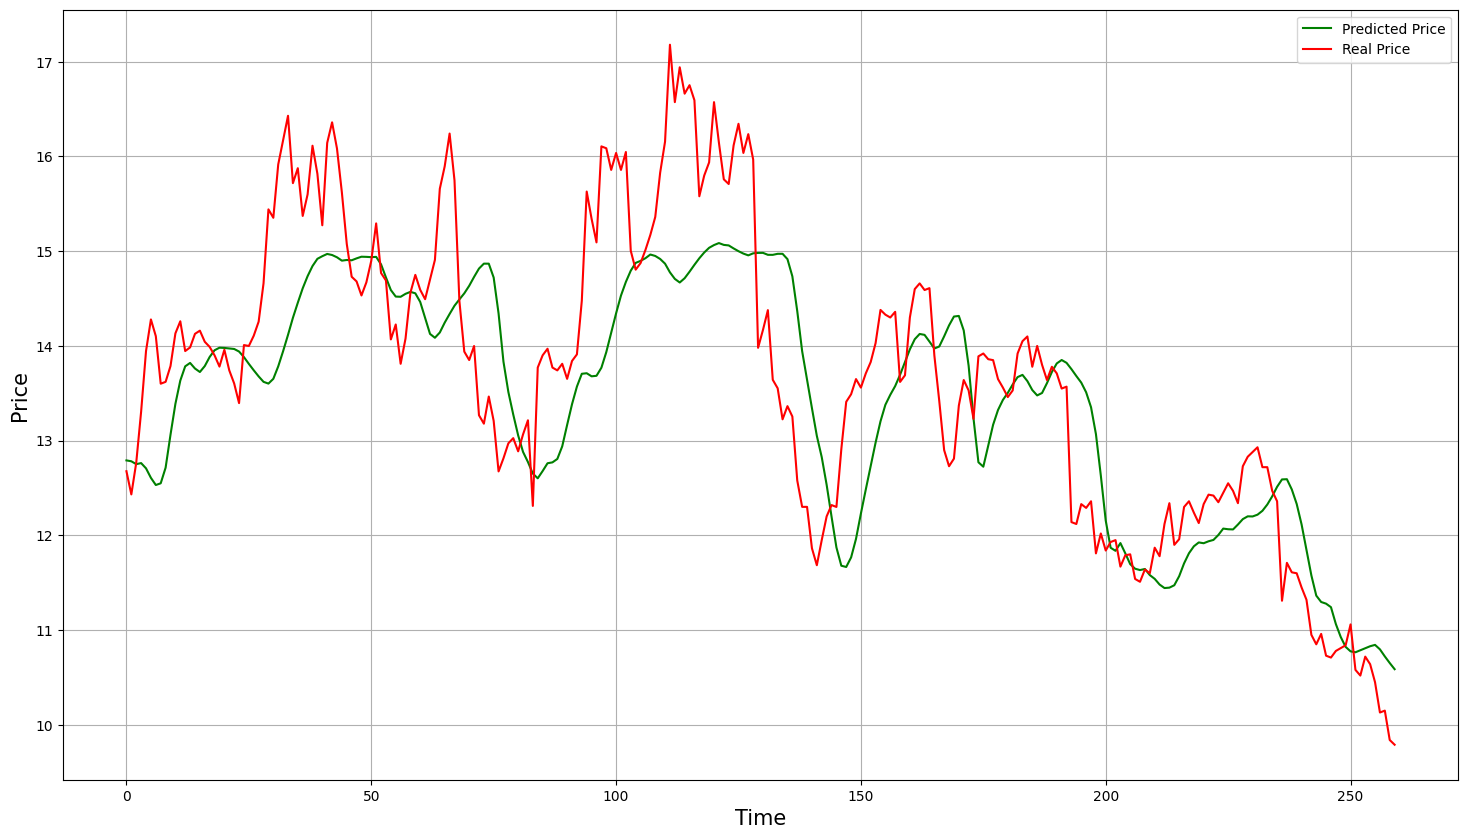

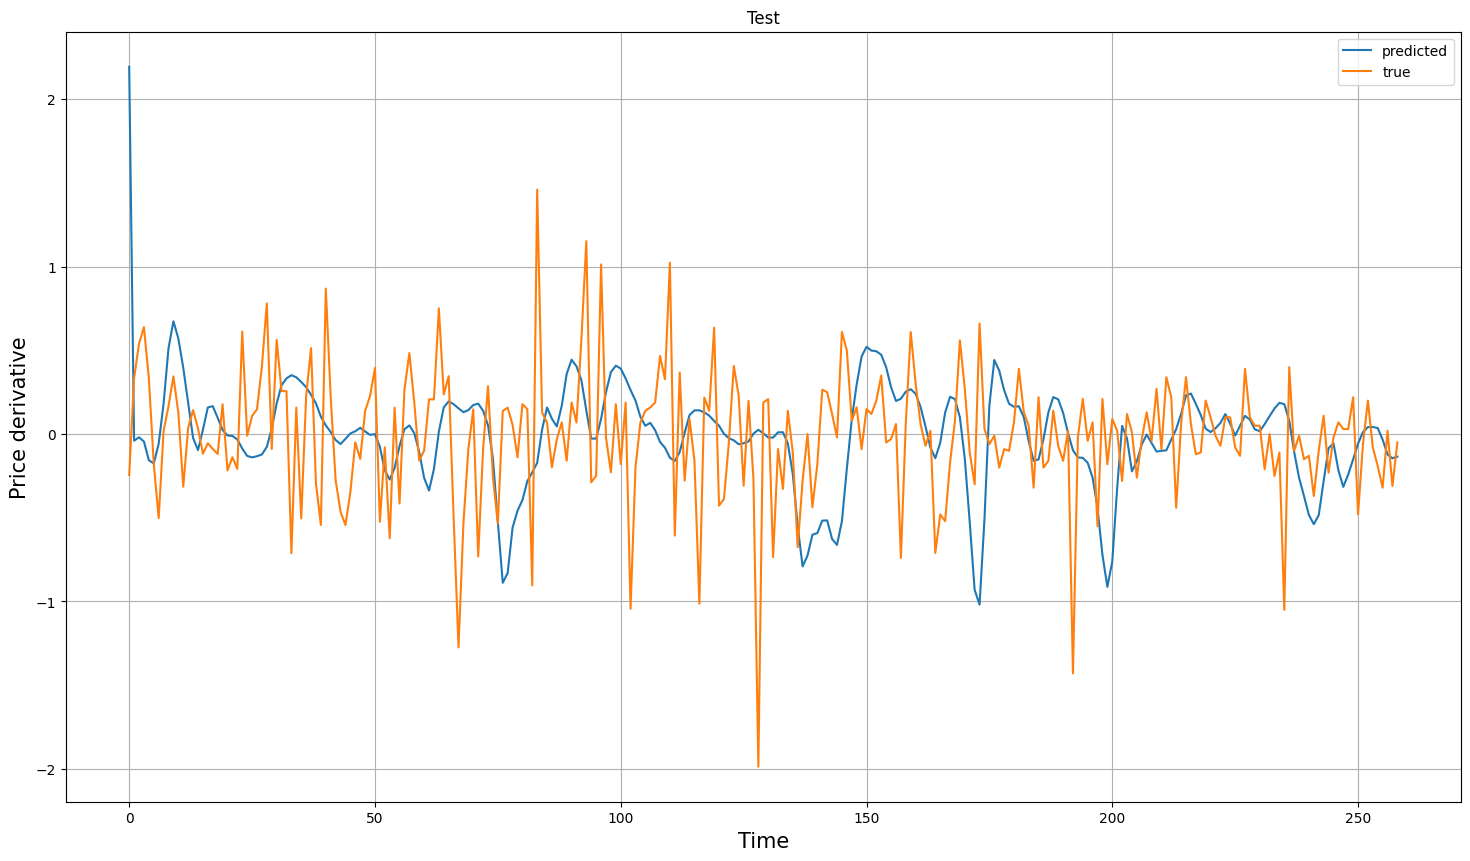

0.5116279069767442


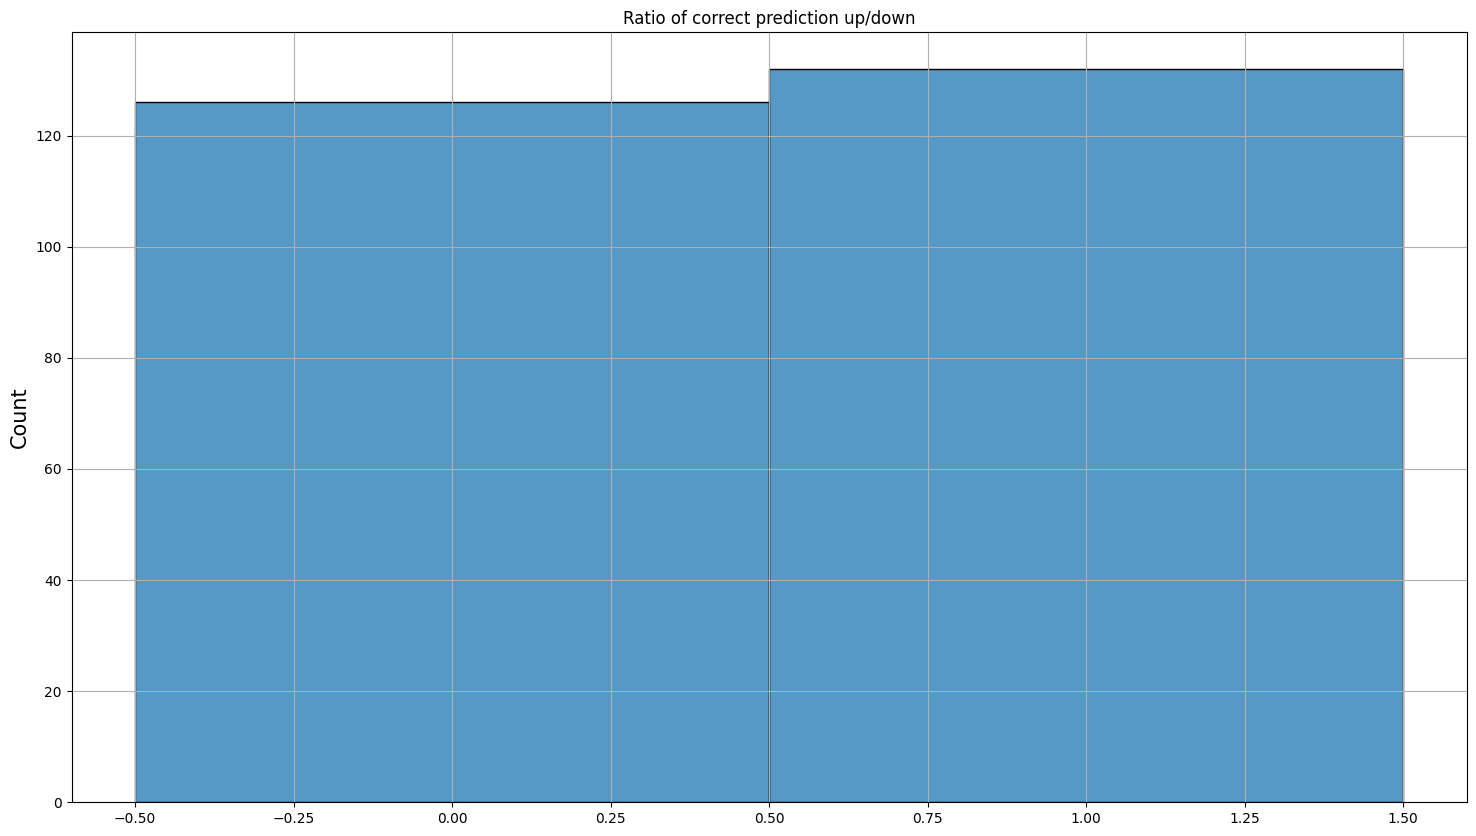

0.009602370068192655 2.749247466274169


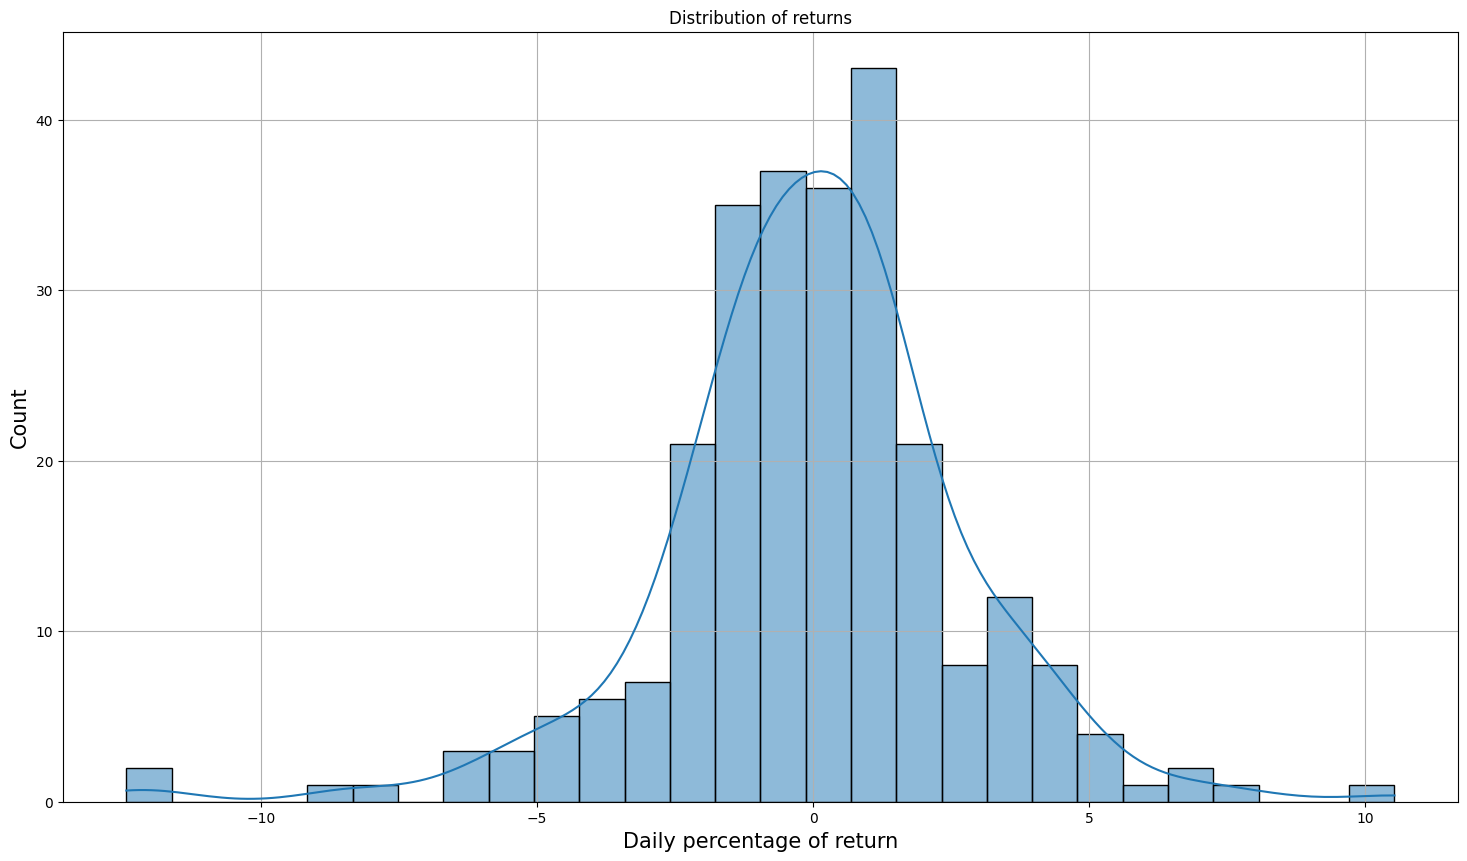

12.387057387968525


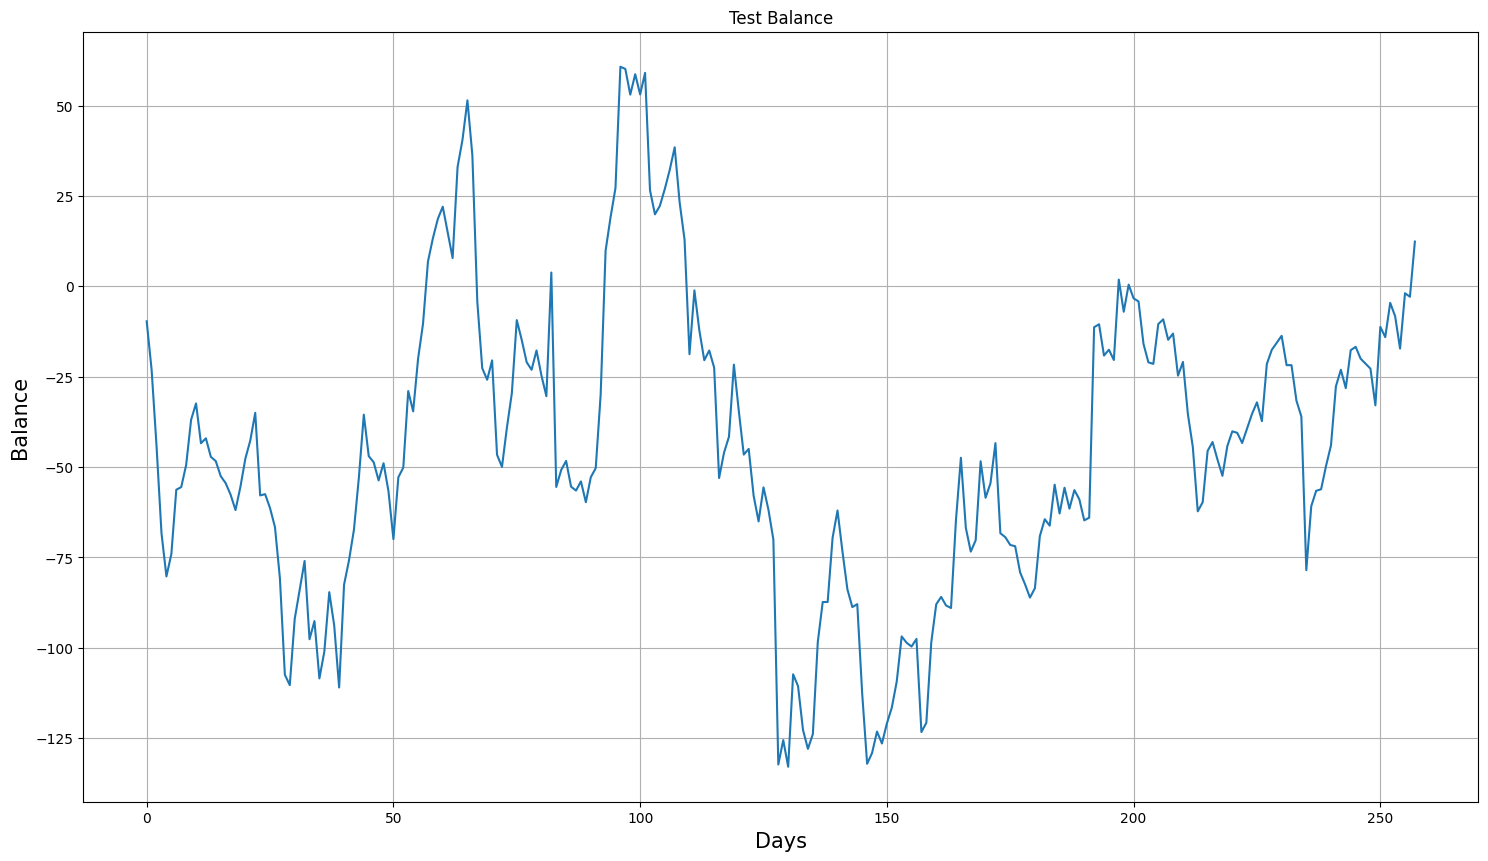

In [6]:
ws = 10
dtp = 1

X_train, X_test, y_train, y_test, y_val = forecast_split(close, window_size=ws, dtp=dtp, test_days=260)
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.transform(y_test)

X_train_reshaped = np.reshape(X_train_scaled, (X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
X_test_reshaped = np.reshape(X_test_scaled, (X_test_scaled.shape[0], X_test_scaled.shape[1], 1))
    
fs = Forecastsimulator(lstm(ws=ws, dtp=dtp, multi=3))
fs.train_nn(X_train_reshaped, y_train_scaled, epochs=50, batch_size=20)
prediction = scaler_y.inverse_transform(fs.predict(X_test_reshaped))

fs.plot_prediction(prediction, y_test)
fs.simulate(prediction, y_test)
del fs